In [6]:
pip install statsmodels econml scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load dataset
data = pd.read_csv('/kaggle/input/heart-disease-diagnosis-dataset/dataset_heart.csv')

# Display the first few rows of the dataset to check column names and initial values
print(data.head())

# Renaming columns for readability
data.columns = [
    'age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'serum_cholesterol', 
    'fasting_blood_sugar', 'resting_electrocardiographic', 'max_heart_rate_achieved', 
    'exercise_induced_angina', 'oldpeak', 'slope', 'num_major_vessels', 
    'thal', 'target'
]

# Convert target column to binary (0 for absence, 1 for presence)
data['target'] = data['target'].map({1: 0, 2: 1})

# Define feature and target variable
X = data.drop('target', axis=1)  # Features
y = data['target']               # Target variable

# Define the preprocessing for numerical and categorical data
numeric_features = ['age', 'resting_blood_pressure', 'serum_cholesterol', 
                    'max_heart_rate_achieved', 'oldpeak', 'num_major_vessels']
categorical_features = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 
                        'resting_electrocardiographic', 'exercise_induced_angina', 
                        'slope', 'thal']
# Preprocessing pipeline for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by replacing with mean
    ('scaler', StandardScaler())                  # Standardize numerical features
])

# Preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values by using mode
    ('onehot', OneHotEncoder(drop='first'))                # One-hot encode categorical features
])

# Combine preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply transformations to the dataset
X_preprocessed = preprocessor.fit_transform(X)

# Converting the preprocessed data back to a DataFrame for reference
# This step is not mandatory but can help visualize the output
# Extracting transformed categorical feature names for better readability
categorical_columns = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(categorical_columns)
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# Display the first few rows of the transformed dataset
print(X_preprocessed_df.head())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

print("Data preprocessing complete. Training and testing sets are ready for model training.")

   age  sex   chest pain type  resting blood pressure  serum cholestoral  \
0   70     1                4                     130                322   
1   67     0                3                     115                564   
2   57     1                2                     124                261   
3   64     1                4                     128                263   
4   74     0                2                     120                269   

   fasting blood sugar  resting electrocardiographic results  max heart rate  \
0                    0                                     2             109   
1                    0                                     2             160   
2                    0                                     0             141   
3                    0                                     0             105   
4                    0                                     2             121   

   exercise induced angina  oldpeak  ST segment  major vessels

In [34]:
# Import necessary libraries for modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import statsmodels.formula.api as smf
from econml.grf import CausalForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Step 1: Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Step 2: Random Forest Model
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params, cv=5, n_iter=10, random_state=42)
rf_random_search.fit(X_train, y_train)
best_rf = rf_random_search.best_estimator_
# rf_model = RandomForestClassifier(random_state=42)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)

# Step 3: GLMM Model
# Convert preprocessed data back to DataFrame for statsmodels compatibility
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_train_df['target'] = y_train.reset_index(drop=True)

# Define formula for GLMM, using the first numerical feature as a random effect example
# You may need to adjust this formula based on your grouping structure
glmm_formula = 'target ~ ' + ' + '.join(numeric_features) + ' + ' + ' + '.join(categorical_columns)
glmm_model = smf.mixedlm(glmm_formula, X_train_df, groups=X_train_df['num_major_vessels'])  # Example random effect

# Catch warnings for boundary parameters in GLMM
try:
    glmm_result = glmm_model.fit()
except ConvergenceWarning:
    print("Warning: GLMM model may not have converged.")

glmm_preds = glmm_result.predict(pd.DataFrame(X_test, columns=feature_names))

T_dummy = np.zeros(len(y_train))

# Fit the GMERF model with dummy treatment
gmerf_model = CausalForest()
gmerf_model.fit(y=y_train, T=T_dummy, X=X_train)
gmerf_preds = gmerf_model.predict(X_test).flatten()

# Combine Predictions for Stacking
# Prepare DataFrame for stacking classifier using each model's predictions
stacking_data = pd.DataFrame({
    'dt_preds': dt_preds,
    'rf_preds': rf_preds,
    'glmm_preds': glmm_preds,
    'gmerf_preds': gmerf_preds
})

# Define Meta Learner for Stacking
meta_learner = GradientBoostingClassifier()

# Stacking Classifier
stacked_model = StackingClassifier(
    estimators=[
        ('dt', dt_model),
        ('rf', rf_model),
        # GLMM and GMERF are used separately as they are different in implementation
    ],
    final_estimator=meta_learner
)

# Since we can't add GLMM and GMERF directly into StackingClassifier, we fit them manually and combine predictions
# Fit the stacked model
stacked_model.fit(X_train, y_train)
stacked_preds = stacked_model.predict(X_test)

# Evaluate each model's performance
print("\nIndividual Model Performances:")
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("GLMM Model Accuracy:", accuracy_score(y_test, (glmm_preds > 0.5).astype(int)))
print("GMERF Model Accuracy:", accuracy_score(y_test, (gmerf_preds > 0.5).astype(int)))

weights = [0.2, 0.2, 0.5, 0.4]  # Adjust these based on model performance

# Weighted averaging of predictions
final_preds = (weights[0] * dt_preds + 
               weights[1] * rf_preds + 
               weights[2] * (glmm_preds > 0.5).astype(int) + 
               weights[3] * (gmerf_preds > 0.5).astype(int))

# Convert averaged predictions to binary
final_preds = (final_preds > 0.5).astype(int)

# Evaluate the performance of the weighted averaging model
print("\nWeighted Averaged Model Performance:")
print("Accuracy:", accuracy_score(y_test, final_preds))
print("Precision:", precision_score(y_test, final_preds))
print("Recall:", recall_score(y_test, final_preds))
print("F1 Score:", f1_score(y_test, final_preds))



Individual Model Performances:
Decision Tree Accuracy: 0.7407407407407407
Random Forest Accuracy: 0.7777777777777778
GLMM Model Accuracy: 0.8395061728395061
GMERF Model Accuracy: 0.6049382716049383

Weighted Averaged Model Performance:
Accuracy: 0.8271604938271605
Precision: 0.95
Recall: 0.59375
F1 Score: 0.7307692307692308


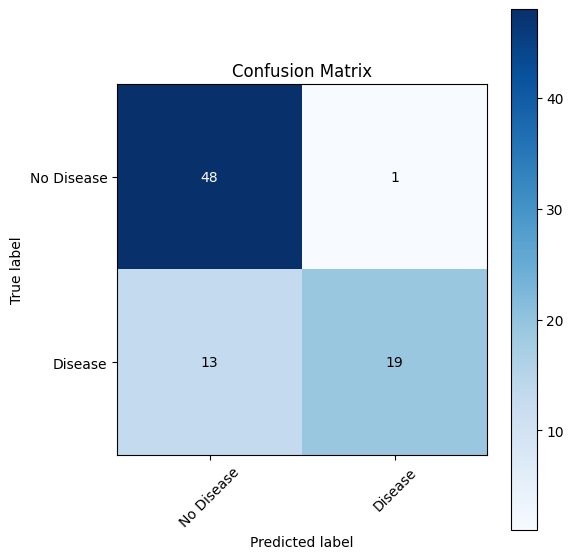

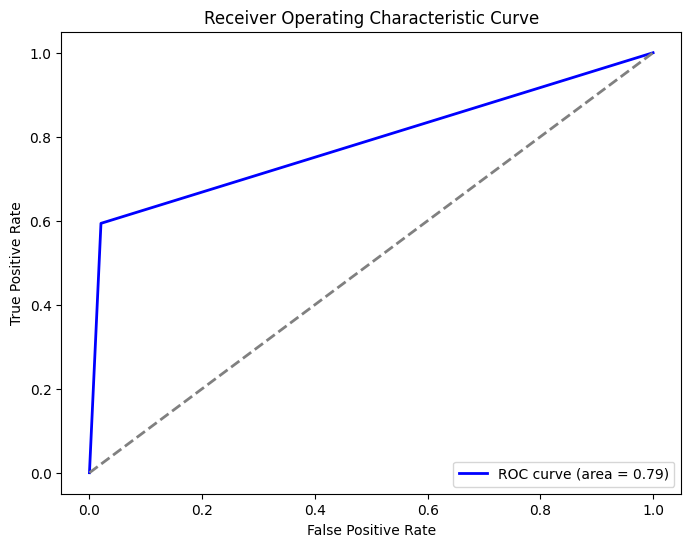

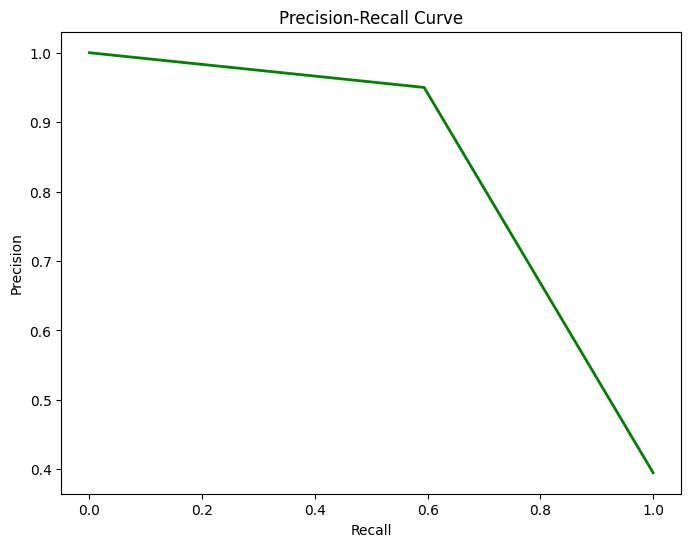

In [35]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Step 1: Generate Confusion Matrix for the Weighted Averaged Model
conf_matrix = confusion_matrix(y_test, final_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = ['No Disease', 'Disease']
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add labels to the matrix
thresh = conf_matrix.max() / 2.
for i, j in enumerate(np.indices(conf_matrix.shape).reshape(2, -1).T):
    plt.text(j[1], j[0], format(conf_matrix[j[0], j[1]], 'd'),
             ha="center", va="center", color="white" if conf_matrix[j[0], j[1]] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Step 2: Generate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, final_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Step 3: Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_preds)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
